## Import Libraries

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

## Functions

In [272]:
def save_image(image, points, path, name):
    image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    points = np.append(points, [points[0]], axis=0)
    for i in range(len(points)-1):
        image_copy = cv2.line(image_copy, points[i], points[i+1], color=(255, 0, 0), thickness=1)
    cv2.imwrite(f'{path}/{name}.jpg', image_copy)


def save_video(path, n_frames):
    img = []
    for i in range(n_frames):
        img.append(cv2.imread(path + '/' + str(i) + '.jpg'))
    h, w, _ = img[1].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('contour.mp4', fourcc, 5, (w, h))
    for j in range(n_frames):
        video.write(img[j])
    video.release()


def initialize_points(image_shape, center, radius, n_points):
    height, width = image_shape[:2]
    theta = np.linspace(0, 2*np.pi, n_points)
    x_points = center[0] + np.round(radius[0] * np.cos(theta))
    x_points[x_points < 0] = 0
    x_points[x_points >= width] = width - 1
    y_points = center[1] + np.round(radius[1] * np.sin(theta))
    y_points[y_points < 0] = 0
    y_points[y_points >= height] = height - 1
    points = np.stack((x_points, y_points), axis=-1)
    return points.astype('int')


def calculate_gradient(image):
    gradient = cv2.Canny(image, 100, 255).astype(float)
    gradient = cv2.GaussianBlur(gradient, (21, 21), 0)
    gradient /= np.max(gradient)
    return gradient


def internal_energy(points, alpha):
    points = np.append(points, [points[0]], axis=0)
    dxdy = np.diff(points, axis=0) ** 2
    elasticity = dxdy[:, 0] + dxdy[:, 1]
    d = np.mean(np.sqrt(elasticity))
    E_internal = np.mean((elasticity - alpha * d) ** 2)
    return E_internal, np.mean(elasticity), np.mean(d)


def external_energy(image_gradient, points):
    G = image_gradient[points[:, 1], points[:, 0]]
    E_external = -np.sum(G)
    return E_external


def total_energy(image, image_gradient, points, alpha, lambda_):
    E_internal, _, _ = internal_energy(points, alpha)
    E_external = external_energy(image_gradient, points)
    E_total = E_internal + lambda_ * E_external
    return E_total, E_internal, E_external


def update_points(gray, image_gradient, points, alpha, lambda_, kernel_size):
    margin = kernel_size // 2
    height, width = gray.shape
    E_total, _, _ = total_energy(gray, image_gradient, points, alpha, lambda_)
    new_points = points.copy()
    temp_points = points.copy()
    for i, point in enumerate(points):
        x_start = np.maximum(point[0] - margin, 0).astype(int)
        x_end = np.minimum(point[0] + margin, width).astype(int)
        y_start = np.maximum(point[1] - margin, 0).astype(int)
        y_end = np.minimum(point[1] + margin, height).astype(int)
        # print(point, x_start, x_end, y_start, y_end)

        E_total_copy = E_total
        for x in range(x_start, x_end):
            for y in range(y_start, y_end):
                temp_points[i, :] = [x, y]
                new_E_total, _, _ = total_energy(gray, image_gradient, temp_points, alpha, lambda_)
                if new_E_total < E_total_copy:
                    # print(f'{new_E_total}, {E_total_copy}, {point}, [{x}, {y}]')
                    new_points[i, :] = [x, y]
                    E_total_copy = new_E_total
        temp_points[i, :] = point

    return new_points


def active_contour(image, gray, init_points, alpha=1, lambda_=0, kernel_size=5, n_iter=10):
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_gradient = calculate_gradient(gray)
    points = init_points

    path = 'results'
    !mkdir 'results'
    for iter in tqdm(range(n_iter)):
        points = update_points(gray, image_gradient, points, alpha, lambda_, kernel_size)
        save_image(image, points, path, iter)
    points = np.append(points, [points[0]], axis=0)
    return points

## Load Image

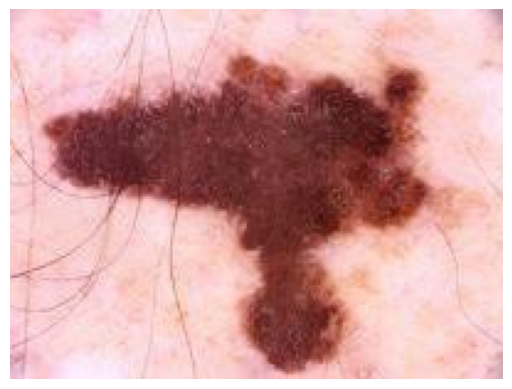

In [241]:
image = cv2.imread('melanoma.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(image)
plt.axis('off')
plt.show()

## Preprocessing

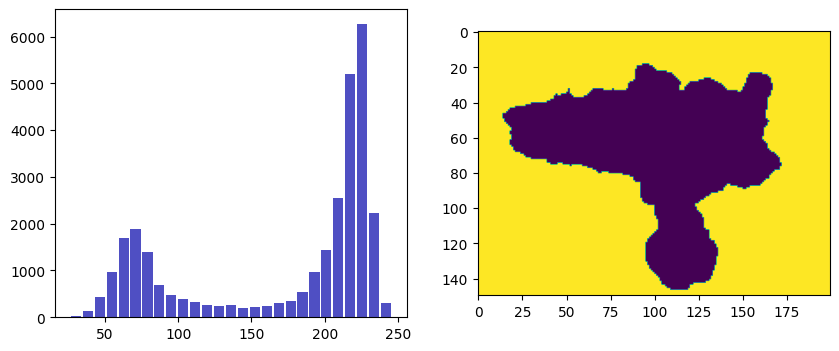

In [244]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(x=gray.reshape(-1), bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85);
thresh_image = gray.copy()
thresh_image = cv2.GaussianBlur(thresh_image, (5, 5), 0)
plt.subplot(1, 2, 2)
ret, thresh_image = cv2.threshold(thresh_image, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh_image)
plt.show()

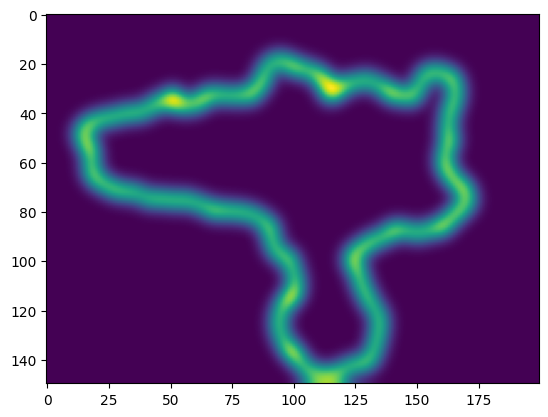

In [273]:
image_gradient = calculate_gradient(thresh_image)
plt.imshow(image_gradient)
plt.show()

## Contour

mkdir: cannot create directory ‘results’: File exists


  0%|          | 0/200 [00:00<?, ?it/s]

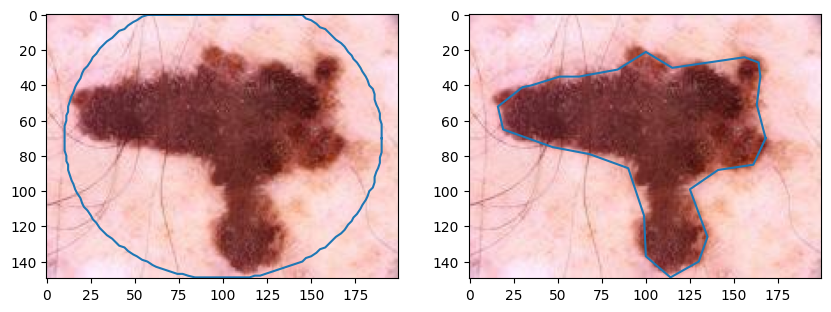

In [274]:
n_iter = 200
init_points = initialize_points(image.shape[:2], center=[100, 70], radius=(90, 80), n_points=180)
points = active_contour(image, thresh_image, init_points, alpha=1e-4, lambda_=1e9, kernel_size=5, n_iter=n_iter)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.plot(init_points[:, 0], init_points[:, 1])
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.plot(points[:, 0], points[:, 1])
plt.show()

save_video('results', n_iter)